In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Activation, TimeDistributed, Flatten, Conv2D
from keras.optimizers import RMSprop, Adam

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import tensorflow as tf
%matplotlib notebook

Using TensorFlow backend.


In [3]:
print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(keras.__version__)

1.13.3
0.20.3
1.4.0-rc0
2.0.8


In [4]:
#f = open('sp500.csv', 'rb').read()
#data = f.decode().split('\n')def updown(a,b):

In [5]:

# load csv as np array
raw = np.loadtxt(open('./data_mkt/DJI-ohlc.csv'), delimiter=',')
len(raw)

8260

In [6]:
type(raw), len(raw[0]), raw[0], raw[-1]

(numpy.ndarray,
 4,
 array([ 1277.719971,  1295.48999 ,  1266.890015,  1292.619995]),
 array([ 23442.900391,  23517.710938,  23388.910156,  23435.009766]))

In [7]:
# create list of sequences/window of length seqlen
# set sequence length
seqlen = 10
winraw = []
for i in range(len(raw)-seqlen):
    winraw.append(raw[i:i+seqlen,:])

In [8]:
# convert winraw to np.array
wr = np.array(winraw)

In [9]:
wr[0],len(wr), len(wr[0]),type(wr)

(array([[ 1277.719971,  1295.48999 ,  1266.890015,  1292.619995],
        [ 1297.369995,  1305.099976,  1278.930054,  1287.880005],
        [ 1283.23999 ,  1293.400024,  1272.640015,  1286.77002 ],
        [ 1276.939941,  1286.109985,  1269.77002 ,  1277.719971],
        [ 1272.079956,  1294.939941,  1268.98999 ,  1290.079956],
        [ 1294.060059,  1301.130005,  1278.599976,  1285.22998 ],
        [ 1284.890015,  1294.5     ,  1275.069946,  1280.589966],
        [ 1285.      ,  1297.040039,  1279.810059,  1290.079956],
        [ 1290.079956,  1297.150024,  1281.359985,  1289.969971],
        [ 1287.98999 ,  1291.73999 ,  1268.660034,  1276.060059]]),
 8250,
 10,
 numpy.ndarray)

In [10]:
winraw[-1][-1] == raw[-2]

array([ True,  True,  True,  True], dtype=bool)

In [11]:
zz = 0
wr[zz], wr[zz][-1][-1],wr[zz][0][0]

(array([[ 1277.719971,  1295.48999 ,  1266.890015,  1292.619995],
        [ 1297.369995,  1305.099976,  1278.930054,  1287.880005],
        [ 1283.23999 ,  1293.400024,  1272.640015,  1286.77002 ],
        [ 1276.939941,  1286.109985,  1269.77002 ,  1277.719971],
        [ 1272.079956,  1294.939941,  1268.98999 ,  1290.079956],
        [ 1294.060059,  1301.130005,  1278.599976,  1285.22998 ],
        [ 1284.890015,  1294.5     ,  1275.069946,  1280.589966],
        [ 1285.      ,  1297.040039,  1279.810059,  1290.079956],
        [ 1290.079956,  1297.150024,  1281.359985,  1289.969971],
        [ 1287.98999 ,  1291.73999 ,  1268.660034,  1276.060059]]),
 1276.0600589999999,
 1277.719971)

In [12]:
raw[0][-1]

1292.619995

In [13]:
# Helper functions
def updown(a,b):
    # test if next time step is higher or lower
    if a < b:
        return 1
    else:
        return 0

In [18]:
# create y values, up or down of next time step
#yr = []
#for w in wr:
#    yr.append(updown(w[-1][-1],
#                       (w+1)[0][0]))
# create y values, up or down of next time step after last time step of a window
y = []
for w in range(len(raw)):
    w_a = raw[w-1][-1]
    w_b = raw[w][-1]
    #print(w_a[-1],type(w_a[-1]))
    #print(w_b[-1])
    check_updown = updown(w_a,
                          w_b)
    y.append(check_updown)
y=y[seqlen:]
len(y)

(8250, 1)

In [15]:
len(y), y[0], y[-1]


(8250, 1, 1)

In [28]:
# check y against wr values
z = 1000

print(wr[z],wr[z][-1][-1])
#print(rawwin[z][0])
print(y[z])
print(wr[z+1],wr[z+1][-1][-1])

[[ 2222.860107  2235.        2210.540039  2226.070068]
 [ 2223.389893  2236.25      2215.360107  2224.639893]
 [ 2217.139893  2227.5       2203.75      2214.639893]
 [ 2216.070068  2247.320068  2202.5       2238.75    ]
 [ 2241.25      2254.639893  2225.709961  2239.110107]
 [ 2236.610107  2249.459961  2221.25      2235.360107]
 [ 2238.929932  2254.639893  2214.290039  2218.389893]
 [ 2220.889893  2264.820068  2214.820068  2256.429932]
 [ 2260.709961  2277.679932  2242.320068  2265.889893]
 [ 2261.610107  2303.570068  2252.860107  2291.070068]] 2291.070068
1
[[ 2223.389893  2236.25      2215.360107  2224.639893]
 [ 2217.139893  2227.5       2203.75      2214.639893]
 [ 2216.070068  2247.320068  2202.5       2238.75    ]
 [ 2241.25      2254.639893  2225.709961  2239.110107]
 [ 2236.610107  2249.459961  2221.25      2235.360107]
 [ 2238.929932  2254.639893  2214.290039  2218.389893]
 [ 2220.889893  2264.820068  2214.820068  2256.429932]
 [ 2260.709961  2277.679932  2242.320068  2265.889

In [101]:
len(wr)==len(y)

True

In [102]:
wr[0], len(wr[0])

(array([[ 1277.719971,  1295.48999 ,  1266.890015,  1292.619995],
        [ 1297.369995,  1305.099976,  1278.930054,  1287.880005],
        [ 1283.23999 ,  1293.400024,  1272.640015,  1286.77002 ],
        [ 1276.939941,  1286.109985,  1269.77002 ,  1277.719971],
        [ 1272.079956,  1294.939941,  1268.98999 ,  1290.079956],
        [ 1294.060059,  1301.130005,  1278.599976,  1285.22998 ],
        [ 1284.890015,  1294.5     ,  1275.069946,  1280.589966],
        [ 1285.      ,  1297.040039,  1279.810059,  1290.079956],
        [ 1290.079956,  1297.150024,  1281.359985,  1289.969971],
        [ 1287.98999 ,  1291.73999 ,  1268.660034,  1276.060059]]), 10)

In [103]:
wr.shape, type(wr)

((8250, 10, 4), numpy.ndarray)

In [104]:
winarr = np.array(wr)
#winnorm = normalize_window3(winarr)

In [105]:
winarr.shape,type(winarr),type(winarr[0]),type(winarr[0][0]),type(winarr[0][0][0])

((8250, 10, 4), numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.float64)

In [106]:
winarr[0],winarr[0][0][0]

(array([[ 1277.719971,  1295.48999 ,  1266.890015,  1292.619995],
        [ 1297.369995,  1305.099976,  1278.930054,  1287.880005],
        [ 1283.23999 ,  1293.400024,  1272.640015,  1286.77002 ],
        [ 1276.939941,  1286.109985,  1269.77002 ,  1277.719971],
        [ 1272.079956,  1294.939941,  1268.98999 ,  1290.079956],
        [ 1294.060059,  1301.130005,  1278.599976,  1285.22998 ],
        [ 1284.890015,  1294.5     ,  1275.069946,  1280.589966],
        [ 1285.      ,  1297.040039,  1279.810059,  1290.079956],
        [ 1290.079956,  1297.150024,  1281.359985,  1289.969971],
        [ 1287.98999 ,  1291.73999 ,  1268.660034,  1276.060059]]),
 1277.719971)

In [107]:
# normalize X
for w in winarr:
    #print(w[0][0])
    w/=w[0][0]
    w -= 1

In [108]:
winarr[-1]

array([[  0.00000000e+00,   3.71630540e-03,  -1.64965929e-05,
          3.05229569e-03],
       [  8.81003539e-04,   3.46987140e-03,  -1.49264702e-03,
          3.28790115e-03],
       [  5.11318750e-03,   1.04694250e-02,   4.96590238e-03,
          1.04603730e-02],
       [  1.13404460e-02,   1.21816038e-02,   8.09239052e-03,
          8.09239052e-03],
       [  1.12464576e-02,   1.72442017e-02,   1.10927430e-02,
          1.53604581e-02],
       [  1.48982993e-02,   1.57827713e-02,   7.10259395e-03,
          1.04963272e-02],
       [  1.27239616e-02,   1.61435818e-02,   1.27239616e-02,
          1.35888915e-02],
       [  1.43815747e-02,   1.56914055e-02,   1.15228392e-02,
          1.50325563e-02],
       [  1.38007249e-02,   1.47969509e-02,   1.04273798e-02,
          1.13313940e-02],
       [  1.22184885e-02,   1.38266964e-02,   1.07098525e-02,
          1.25658479e-02]])

In [109]:
winarr.shape

(8250, 10, 4)

In [110]:
type(winarr), type(y), type(wr)

(numpy.ndarray, list, numpy.ndarray)

In [111]:
# convert yr and winnorm to np.array
yarr = np.array(y)
#winnormarr = np.array(winnorm)

In [112]:
type(winarr), type(yarr), type(wr)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [113]:
yarr.shape, winarr.shape

((8250,), (8250, 10, 4))

In [114]:
# concat y to winnorm(x)
yarr = np.reshape(yarr,(yarr.shape[0],1))
yarr.shape, winarr.shape

((8250, 1), (8250, 10, 4))

In [115]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
#x_data,y_data = unison_shuffled_copies(x_data,y_data)

In [116]:
row = round(0.9 * winarr.shape[0])

In [117]:
#train = winnormarr[:int(row), :]

In [118]:
#np.random.shuffle(train)

In [119]:
x_train = winarr[:row]
y_train = yarr[:row]

In [121]:
x_test = winarr[int(row):]
y_test = yarr[int(row):]

In [122]:
x_train.shape,y_train.shape, x_test.shape, y_test.shape

((7425, 10, 4), (7425, 1), (825, 10, 4), (825, 1))

In [123]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2])) 

In [124]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7425, 10, 4), (7425, 1), (825, 10, 4), (825, 1))

In [125]:
inputshape = ( x_train.shape[1], x_train.shape[2]) #,x_train.shape[3])
print(inputshape)

(10, 4)


In [126]:
# define the input shape
inp = Input(shape=inputshape)

In [127]:

#print('our input shape is ',(x_train.shape[1], x_train.shape[2]) )
#x = TimeDistributed(Conv2D(32,(2,2), activation='relu'))(inp)
#x = TimeDistributed(Flatten())(x)

x = LSTM(32, return_sequences = True)(inp) 
#x = Dropout(0.2)(x)
x = LSTM(64, return_sequences = False)(x)
#x = Dropout(0.2)(x)

#x = TimeDistributed(Conv2D(32,(2,2), activation='relu')0)(x)
x = Dropout(0.2)(x)
#x = Flatten()(x)
output = Dense(1, activation ='sigmoid')(x)

model = Model(inputs = inp, outputs=output )

In [128]:
#optimizer = RMSprop(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [129]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10, 4)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 32)            4736      
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 29,633
Trainable params: 29,633
Non-trainable params: 0
_________________________________________________________________


In [131]:
history = model.fit(x_train, y_train,
                    batch_size = 64, 
                    epochs=100, 
                    verbose=1, 
                    validation_data=(x_test, y_test))

Train on 7425 samples, validate on 825 samples
Epoch 1/100
7425/7425 [==============================] - 2s - loss: 0.6915 - acc: 0.5323 - val_loss: 0.6914 - val_acc: 0.5309
Epoch 2/100
7425/7425 [==============================] - 2s - loss: 0.6913 - acc: 0.5323 - val_loss: 0.6914 - val_acc: 0.5309
Epoch 3/100
7425/7425 [==============================] - 2s - loss: 0.6914 - acc: 0.5323 - val_loss: 0.6914 - val_acc: 0.5309
Epoch 4/100
7425/7425 [==============================] - 2s - loss: 0.6912 - acc: 0.5323 - val_loss: 0.6914 - val_acc: 0.5309
Epoch 5/100
7425/7425 [==============================] - 2s - loss: 0.6912 - acc: 0.5323 - val_loss: 0.6915 - val_acc: 0.5309
Epoch 6/100
7425/7425 [==============================] - 2s - loss: 0.6913 - acc: 0.5325 - val_loss: 0.6916 - val_acc: 0.5309
Epoch 7/100
7425/7425 [==============================] - 2s - loss: 0.6911 - acc: 0.5323 - val_loss: 0.6915 - val_acc: 0.5309
Epoch 8/100
7425/7425 [==============================] - 2s - loss: 0.6

In [132]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

<IPython.core.display.Javascript object>


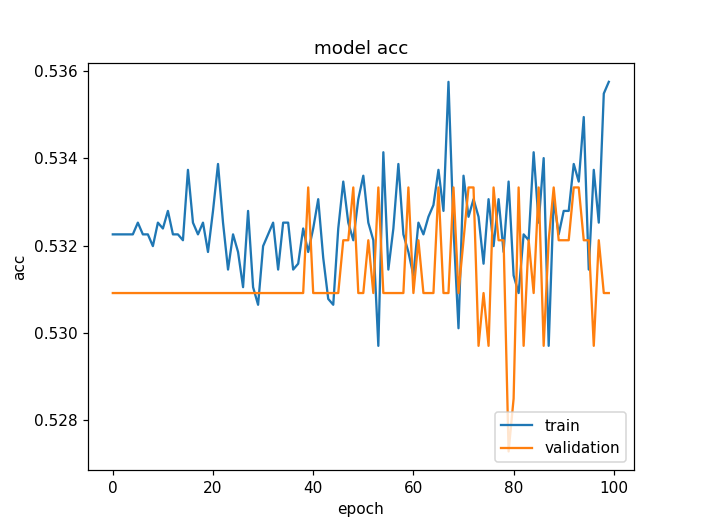

In [133]:
plot_train(history)

In [136]:
evaluation = model.evaluate(x_test, y_test, batch_size=512)
print('Model Accuracy = {:.2f} %'.format(evaluation[1]*100))
print('Model Loss = {:05.2f}'.format(evaluation[0]))

512/825 [=================>............] - ETA: 0sModel Accuracy = 53.09 %
Model Loss = 00.69
